In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from model_pvp import model_pvp
from make_prob_matrix import make_prob_matrix
from get_prob_matrix import get_prob_matrix
from scipy.stats import anderson_ksamp
from bootstrap_jsd import bootstrap_jsd
from scipy.spatial.distance import jensenshannon

In [65]:
# Read data

games = pd.read_excel('../Results.xlsx', sheet_name='Games')
turns = pd.read_excel('../Results.xlsx', sheet_name='Turns')
pve_games = games.query('GameState == "END" and (idPerson1 == 10 or idPerson2 == 10)'
                        ' and (idPerson1 not in [30, 203, 217]'
                        ' and idPerson2 not in [30, 203, 217])')
player_border_games = pve_games.query('idPerson1 == 10')
player_center_games = pve_games.query('idPerson2 == 10')
player_border_games_ids = player_border_games['idGame']
player_center_games_ids = player_center_games['idGame']

prob_real_center = np.load(f"..\\data\\experiment_pve_center_pmf.npy")[:1000]
prob_real_border = np.load(f"..\\data\\experiment_pve_border_pmf.npy")[:1000]
prob_real_pvp = np.load(f"..\\data\\experiment_pvp_pmf.npy")[:1000]

In [66]:
# Put data into arrays
N = 16

player_border_turns = []
player_border_states = []
player_center_turns = []
player_center_states = []

player_center_choices = []
player_border_games_turns_timestamps = []
player_center_games_turns_timestamps = []

for i in player_border_games_ids:
    player_border_game_i_turns = turns.query('Games_idGame == ' + str(i))
    player_border_games_turns_timestamps.append(player_border_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in player_border_game_i_turns.sort_values(by='idTurn')['State']:
        player_border_states.append(state)
    player_border_turns.append(max(player_border_game_i_turns['idTurn']))

for i in player_center_games_ids:
    player_center_game_i_turns = turns.query('Games_idGame == ' + str(i))
    player_center_choices.append(player_center_game_i_turns.sort_values(by='idTurn')['Turn'])
    player_center_games_turns_timestamps.append(player_center_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in player_center_game_i_turns.sort_values(by='idTurn')['State']:
        player_center_states.append(state)
    player_center_turns.append(max(player_center_game_i_turns['idTurn']))

qr_real_matrix_center, probability_matrix_center, counts_center = get_prob_matrix(N, player_center_states, return_counts=True)
_, prob_real_center_model, (_, _) = model_pvp(N, qr_real_matrix_center, num_steps=999)
qr_real_matrix_border, probability_matrix_border, counts_border = get_prob_matrix(N, player_border_states, return_counts=True)
_, prob_real_border_model, (_, _) = model_pvp(N, qr_real_matrix_border, num_steps=999)

In [67]:
bin_width = 8

bins_ranges_border = []
bins_ranges_center = []

for i in np.arange(8, max(player_border_turns) + bin_width, bin_width):
    bins_ranges_border.append(i)

for i in np.arange(8, max(player_center_turns) + bin_width, bin_width):
    bins_ranges_center.append(i)

PvB

KS-тест

In [68]:
N = 16
epsilon_vals = np.arange(0.01, 0.71, 0.01)
qr_matrices = []
for eps in epsilon_vals:
    qr_matrix = np.load(f"..\\output\\eps_quarter\\pvb\\try_11\\qr\\qr_{eps:.2f}.npy")
    qr_matrices.append(qr_matrix)

pmf_epsilon = []
for qr in qr_matrices:
    _, prob, (_, _) = model_pvp(N, qr, num_steps=999)
    pmf_epsilon.append(prob)

#real_qr_matrix = np.load("..\\data\\experiment_pve_center_pmf.npy")
#_, prob_real, (_, _) = model_pvp(N, real_qr_matrix, num_steps=10000)
#qr_real_matrix, probability_matrix_center, counts_center = get_prob_matrix(N, player_center_states, return_counts=True)
#_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)
#prob_real = np.load("..\\data\\experiment_pve_center_pmf.npy")

p_values_ks = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real_center_model, prob)
    ks_distances.append(ks_stat)
    p_values_ks.append(p_value)

# Нахождение оптимального ε
optimal_epsilon_pvb_ks = epsilon_vals[np.argmin(ks_distances)]
optimal_prob_pvb_ks = pmf_epsilon[np.argmin(ks_distances)]
optimal_p_value_ks = p_values_ks[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon_pvb_ks:.3f}")

Оптимальное ε: 0.010


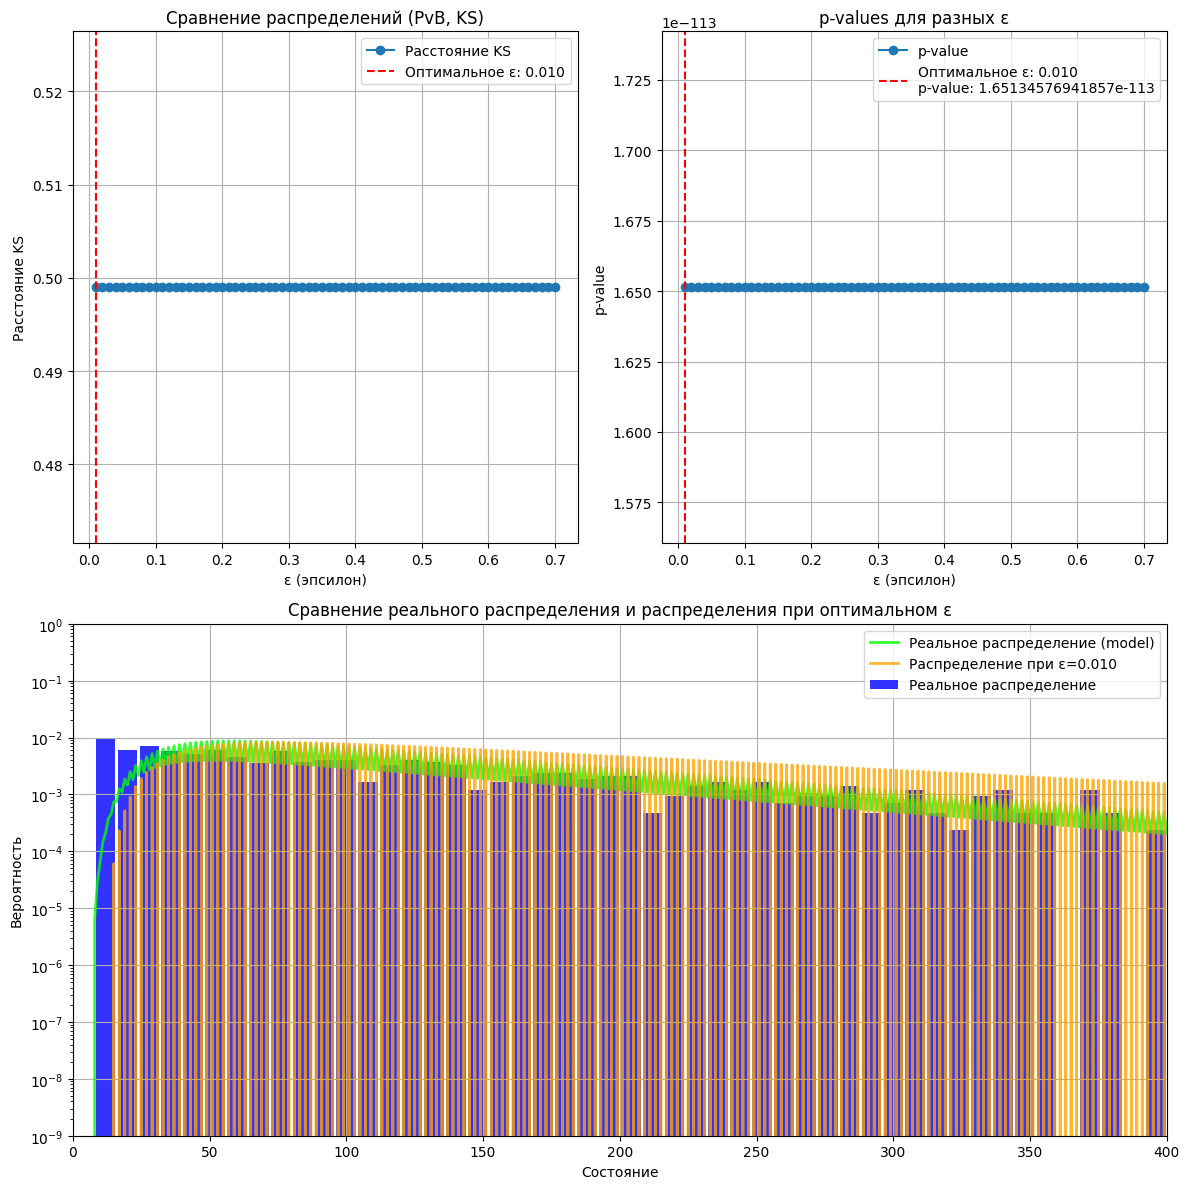

In [69]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon_pvb_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvb_ks:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений (PvB, KS)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_ks, marker='o', label='p-value')
plt.axvline(optimal_epsilon_pvb_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvb_ks:.3f}\np-value: {optimal_p_value_ks}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [player_center_turns[i:i+bin_size].mean() for i in range(0, len(player_center_turns), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_center, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)
plt.plot(prob_real_center_model, label='Реальное распределение (model)', linestyle='-', color='lime', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvb_ks, label=f'Распределение при ε={optimal_epsilon_pvb_ks:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
plt.hist(player_center_turns, bins = bins_ranges_center, density=True, color="blue", alpha=0.8, rwidth=0.9, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

JSD-тест

In [70]:
js_distances = []
p_values_js = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real_center_model, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real_center_model, prob)
    p_values_js.append(p_value)

optimal_epsilon_pvb_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_pvb_js = pmf_epsilon[np.argmin(js_distances)]
optimal_p_value_pvb_js = p_values_js[np.argmin(js_distances)]
print(f"Оптимальное ε (JSD): {optimal_epsilon_pvb_js:.3f}")

Оптимальное ε (JSD): 0.010


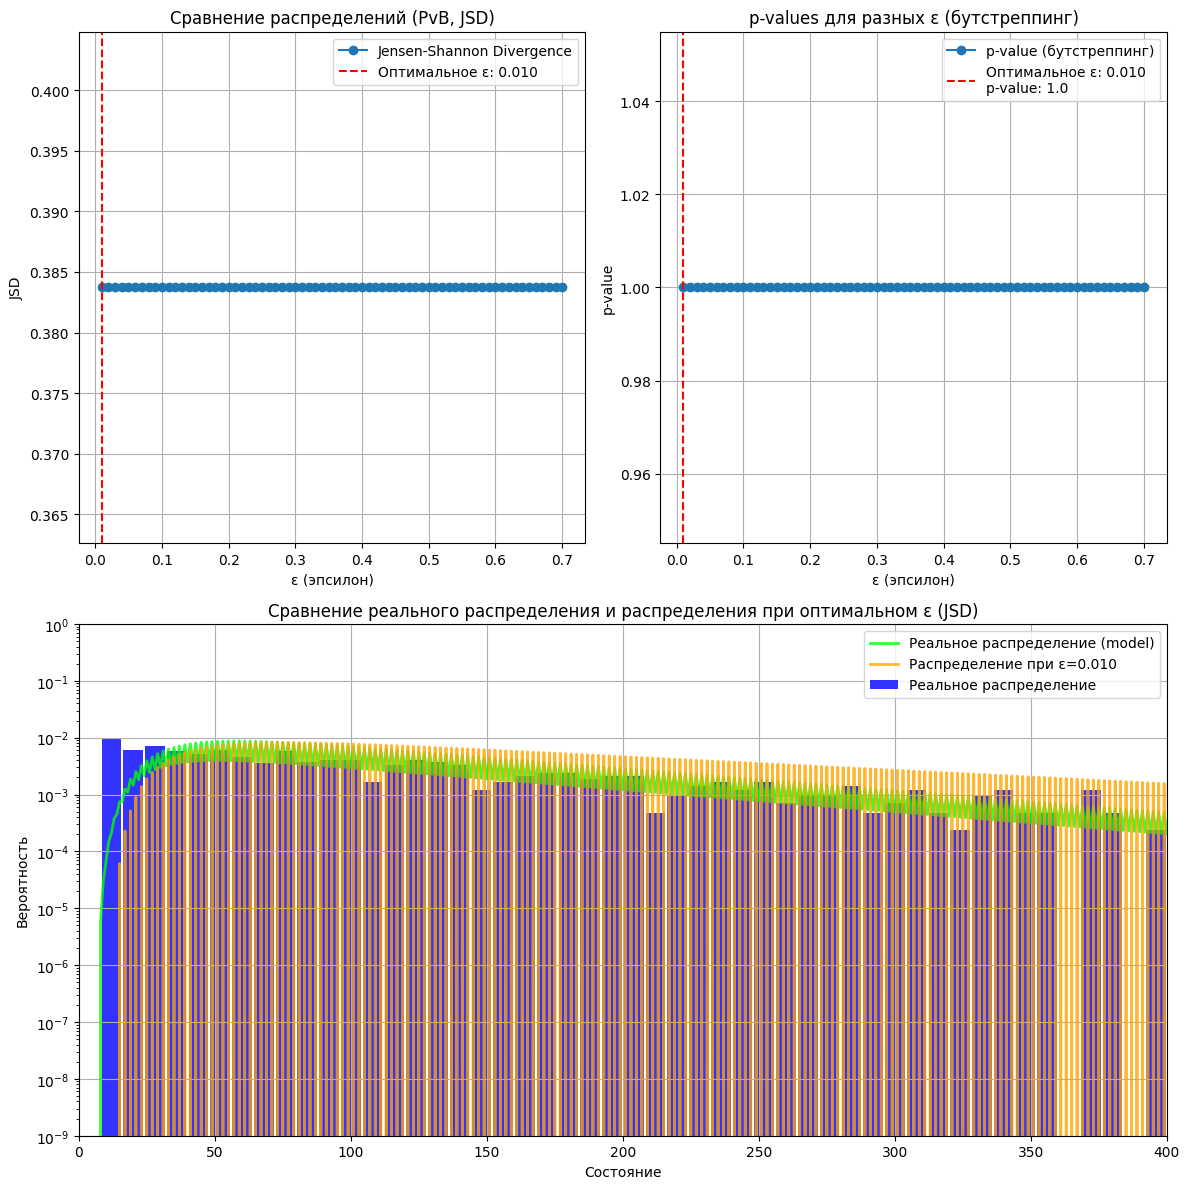

In [71]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_pvb_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvb_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (PvB, JSD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_js, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_pvb_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvb_js:.3f}\np-value: {optimal_p_value_pvb_js}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [player_center_turns[i:i+bin_size].mean() for i in range(0, len(player_center_turns), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_center, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)
plt.plot(prob_real_center_model, label='Реальное распределение (model)', linestyle='-', color='lime', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvb_js, label=f'Распределение при ε={optimal_epsilon_pvb_js:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
plt.hist(player_center_turns, bins = bins_ranges_center, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

AD-тест

In [72]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real_center_model, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_pvb_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_pvb_ad = pmf_epsilon[np.argmin(ad_stats)]
optimal_p_value_pvb_ad = ad_p_values[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_pvb_ad:.3f}")

Оптимальное ε: 0.010


C:\Users\Илья\AppData\Local\Temp\ipykernel_8012\21245586.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real_center_model, prob])


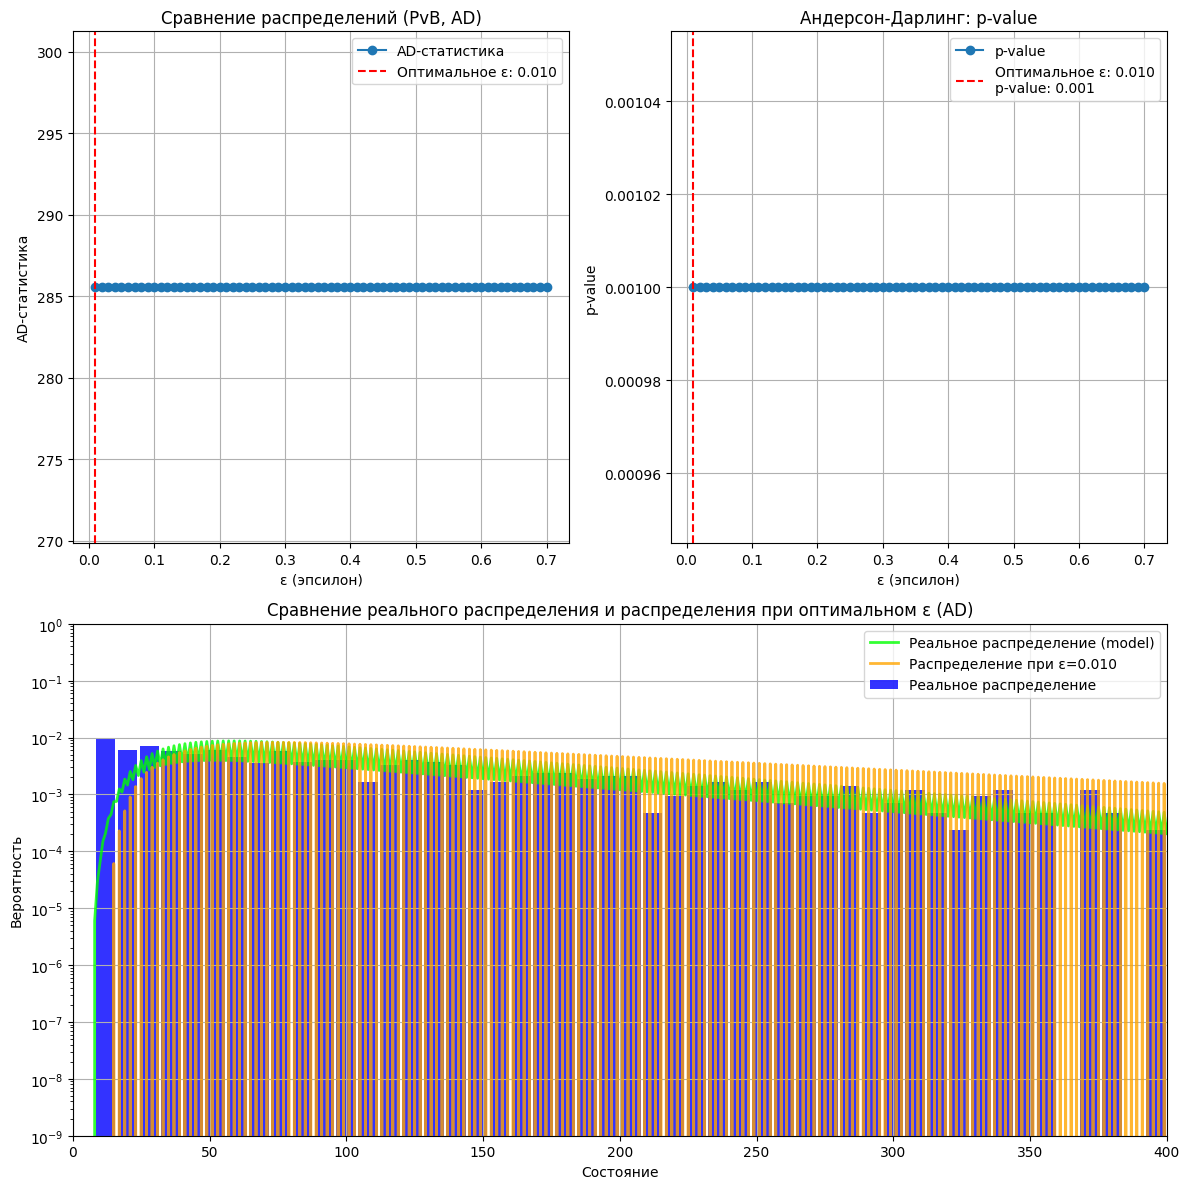

In [73]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_pvb_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvb_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Сравнение распределений (PvB, AD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon_pvb_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvb_ad:.3f}\np-value: {optimal_p_value_pvb_ad}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [player_center_turns[i:i+bin_size].mean() for i in range(0, len(player_center_turns), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_center, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)
plt.plot(prob_real_center_model, label='Реальное распределение (model)', linestyle='-', color='lime', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvb_ad, label=f'Распределение при ε={optimal_epsilon_pvb_ad:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
plt.hist(player_center_turns, bins = bins_ranges_center, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

BvP

KS-тест

In [74]:
N = 16
epsilon_vals = np.arange(0.01, 0.71, 0.01)
qr_matrices = []
for eps in epsilon_vals:
    qr_matrix = np.load(f"..\\output\\eps_quarter\\bvp\\try_11\\qr\\qr_{eps:.2f}.npy")
    qr_matrices.append(qr_matrix)

pmf_epsilon = []
for qr in qr_matrices:
    _, prob, (_, _) = model_pvp(N, qr, num_steps=999)
    pmf_epsilon.append(prob)

#qr_real_matrix, probability_matrix_border, counts_border = get_prob_matrix(N, player_border_states, return_counts=True)
#_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)

p_values_ks = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real_border_model, prob)
    ks_distances.append(ks_stat)
    p_values_ks.append(p_value)

# Нахождение оптимального ε
optimal_epsilon_bvp_ks = epsilon_vals[np.argmin(ks_distances)]
optimal_prob_bvp_ks = pmf_epsilon[np.argmin(ks_distances)]
optimal_p_value_bvp_ks = p_values_ks[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon_bvp_ks:.3f}")

Оптимальное ε: 0.110


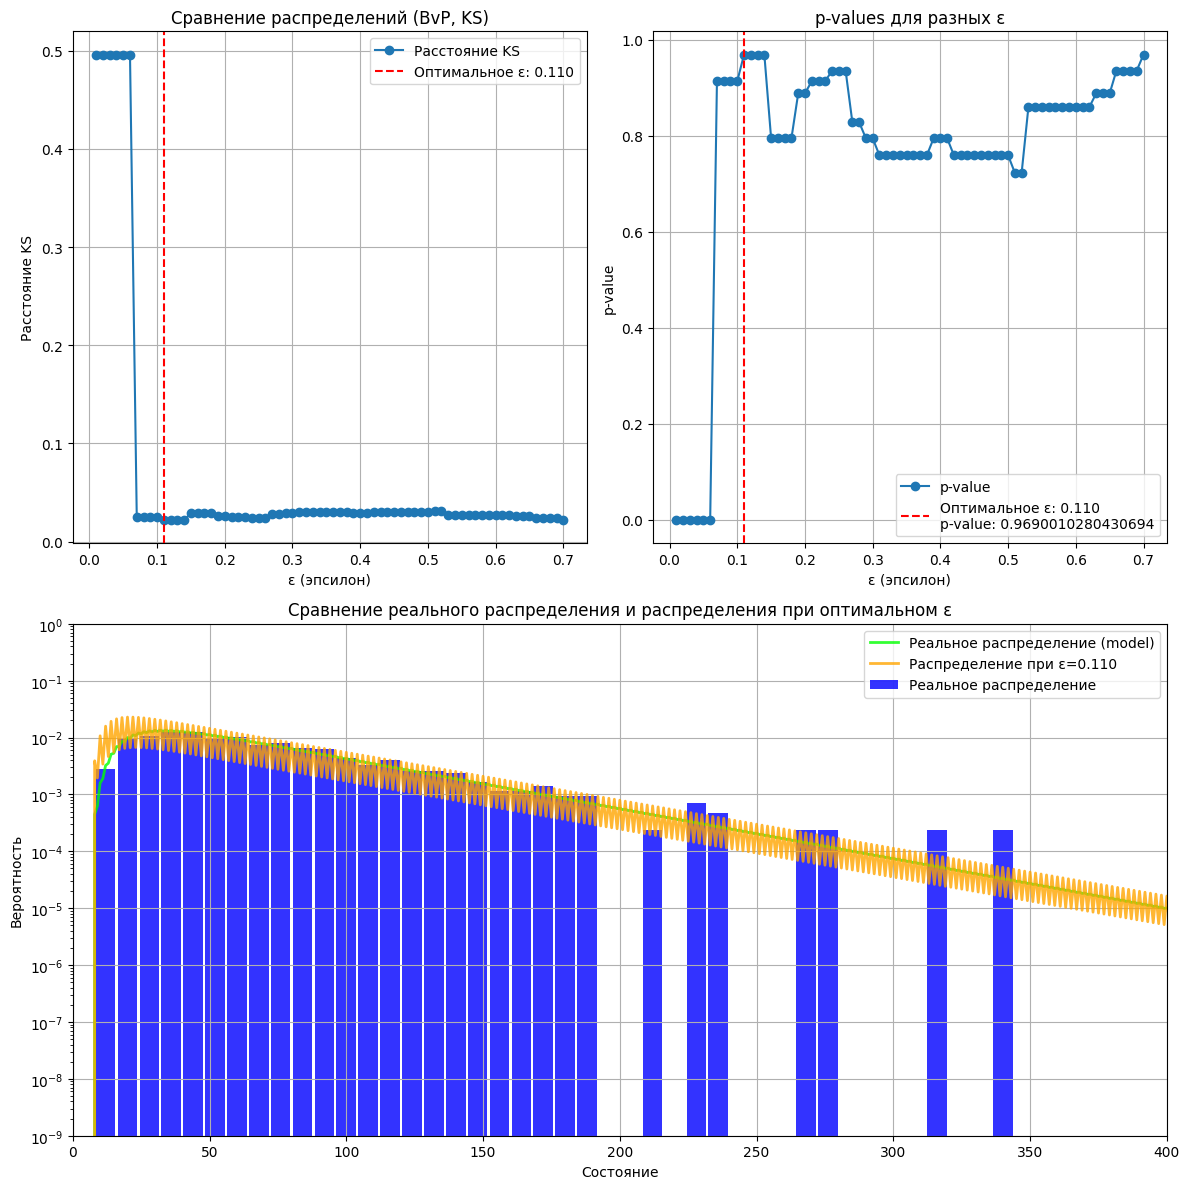

In [75]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon_bvp_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_bvp_ks:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений (BvP, KS)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_ks, marker='o', label='p-value')
plt.axvline(optimal_epsilon_bvp_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_bvp_ks:.3f}\np-value: {optimal_p_value_bvp_ks}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [prob_real_border[i:i+bin_size].mean() for i in range(0, len(prob_real_border), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_border, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)
plt.plot(prob_real_border_model, label='Реальное распределение (model)', linestyle='-', color='lime', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_bvp_ks, label=f'Распределение при ε={optimal_epsilon_bvp_ks:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
plt.hist(player_border_turns, bins = bins_ranges_border, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

JSD-тест

In [76]:
from scipy.spatial.distance import jensenshannon

js_distances = []
p_values_js = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real_border_model, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real_border_model, prob)
    p_values_js.append(p_value)

optimal_epsilon_bvp_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_bvp_js = pmf_epsilon[np.argmin(js_distances)]
optimal_p_value_bvp_js = p_values_js[np.argmin(js_distances)]

print(f"Оптимальное ε (JSD): {optimal_epsilon_bvp_js:.3f}")

Оптимальное ε (JSD): 0.460


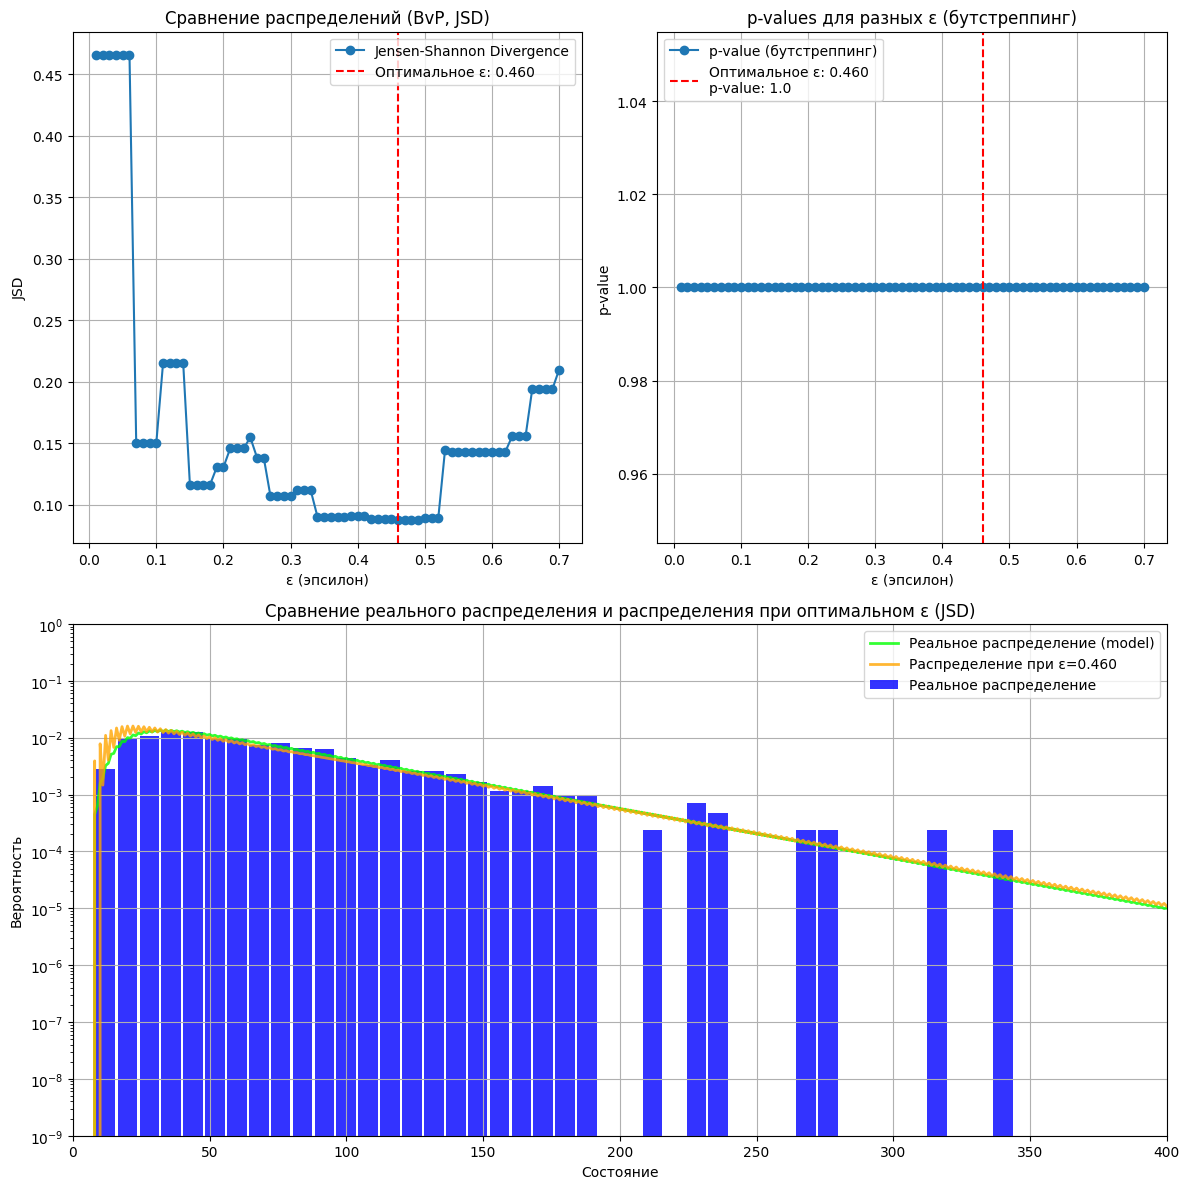

In [77]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_bvp_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_bvp_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (BvP, JSD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_js, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_bvp_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_bvp_js:.3f}\np-value: {optimal_p_value_bvp_js}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [prob_real_border[i:i+bin_size].mean() for i in range(0, len(prob_real_border), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_border, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)
plt.plot(prob_real_border_model, label='Реальное распределение (model)', linestyle='-', color='lime', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_bvp_js, label=f'Распределение при ε={optimal_epsilon_bvp_js:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
plt.hist(player_border_turns, bins = bins_ranges_border, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

AD-тест

In [78]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real_border_model, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_bvp_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_bvp_ad = pmf_epsilon[np.argmin(ad_stats)]
optimal_p_value_bvp_ad = ad_p_values[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_bvp_ad:.3f}")

Оптимальное ε: 0.240


C:\Users\Илья\AppData\Local\Temp\ipykernel_8012\3723908524.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real_border_model, prob])
C:\Users\Илья\AppData\Local\Temp\ipykernel_8012\3723908524.py:3: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real_border_model, prob])


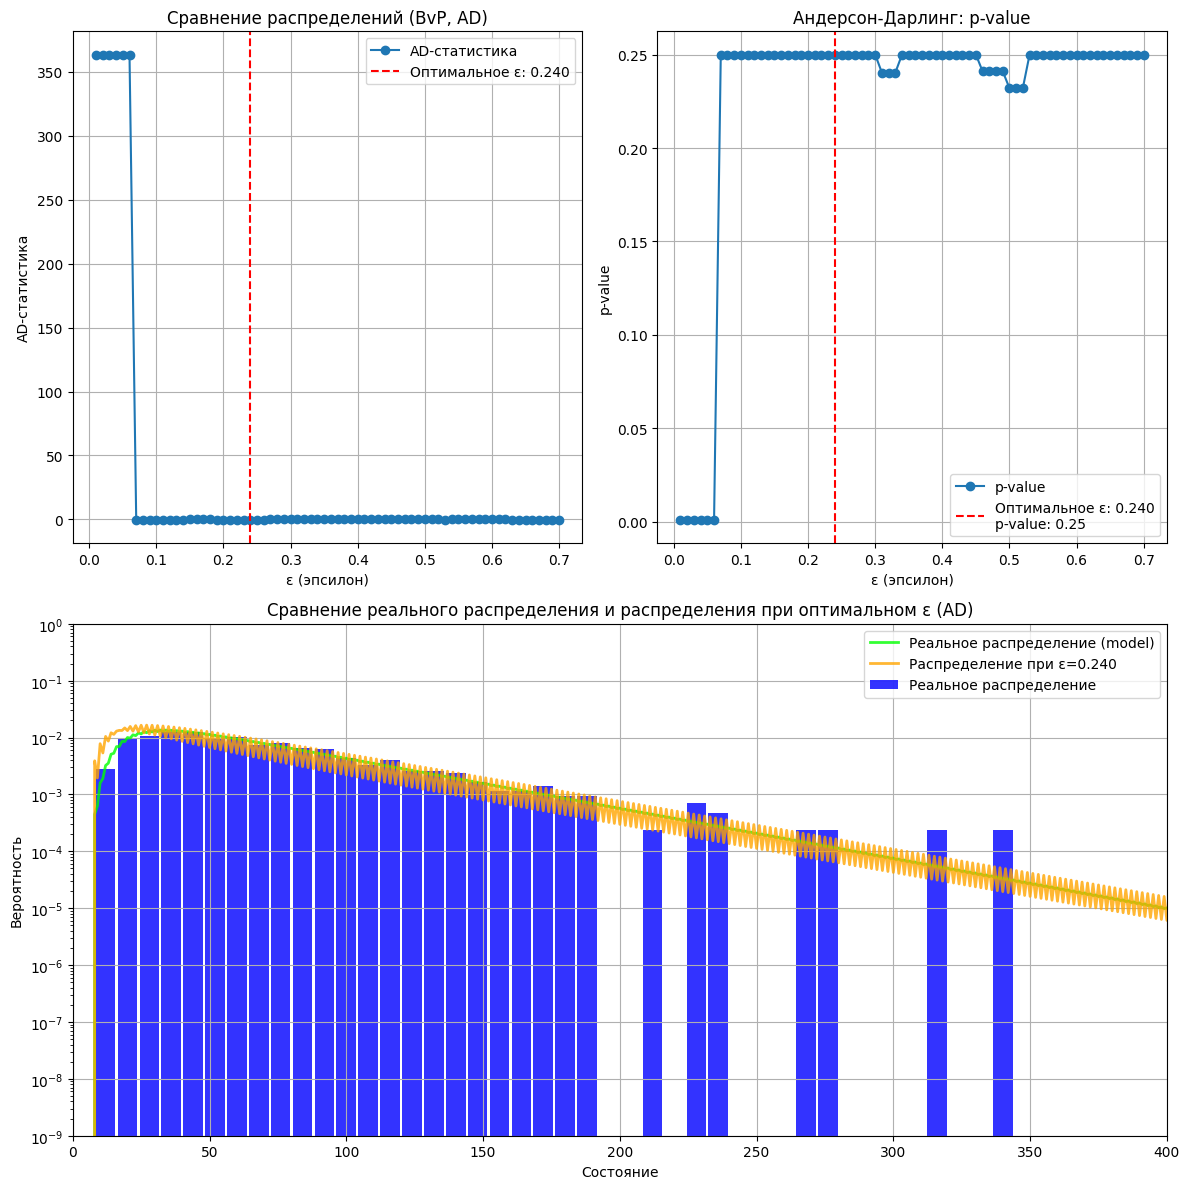

In [79]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_bvp_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_bvp_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Сравнение распределений (BvP, AD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon_bvp_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_bvp_ad:.3f}\np-value: {optimal_p_value_bvp_ad}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [prob_real_border[i:i+bin_size].mean() for i in range(0, len(prob_real_border), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_border, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)
plt.plot(prob_real_border_model, label='Реальное распределение (model)', linestyle='-', color='lime', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_bvp_ad, label=f'Распределение при ε={optimal_epsilon_bvp_ad:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
plt.hist(player_border_turns, bins = bins_ranges_border, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

PvP

Сравнение с распределением границы

KS-тест

In [80]:
N = 16
epsilon_vals = np.arange(0.1, 0.8, 0.1)
qr_matrices = []
for eps in epsilon_vals:
    qr_matrix = np.load(f"..\\output\\eps_quarter\\pvp\\try_8\\qr\\qr_{eps:.2f}.npy")
    qr_matrices.append(qr_matrix)

pmf_epsilon = []
for qr in qr_matrices:
    _, prob, (_, _) = model_pvp(N, qr, num_steps=999)
    pmf_epsilon.append(prob)

#qr_real_matrix, probability_matrix_border, counts_border = get_prob_matrix(N, player_border_states, return_counts=True)
#_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)

p_values_ks = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real_pvp, prob)
    ks_distances.append(ks_stat)
    p_values_ks.append(p_value)

optimal_epsilon_pvp_border_ks = epsilon_vals[np.argmin(ks_distances)]
optimal_prob_pvp_border_ks = pmf_epsilon[np.argmin(ks_distances)]
optimal_p_value_pvp_border_ks = p_values_ks[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon_pvp_border_ks:.3f}")

Оптимальное ε: 0.100


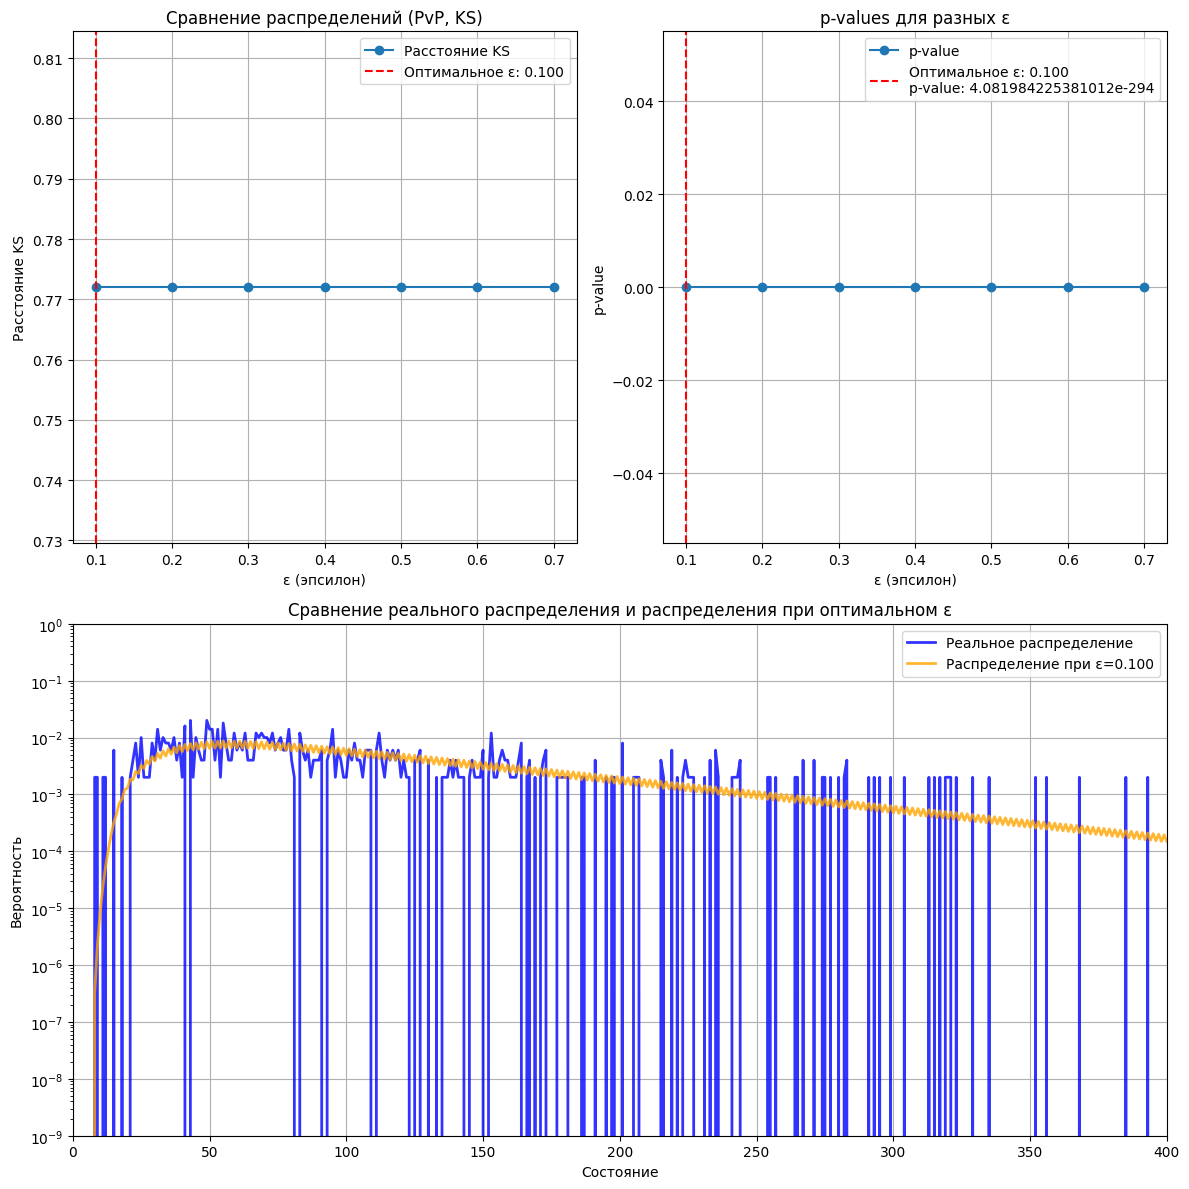

In [81]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon_pvp_border_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_border_ks:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений (PvP, KS)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_ks, marker='o', label='p-value')
plt.axvline(optimal_epsilon_pvp_border_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_border_ks:.3f}\np-value: {optimal_p_value_pvp_border_ks}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [prob_real_border[i:i+bin_size].mean() for i in range(0, len(prob_real_border), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_border, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)

plt.plot(prob_real_pvp, label='Реальное распределение', linestyle='-', color='blue', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvp_border_ks, label=f'Распределение при ε={optimal_epsilon_pvp_border_ks:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
#plt.hist(player_border_turns, bins = bins_ranges_border, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

JSD-тест

In [82]:
from scipy.spatial.distance import jensenshannon

js_distances = []
p_values_js = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real_pvp, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real_pvp, prob)
    p_values_js.append(p_value)

optimal_epsilon_pvp_border_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_pvp_border_js = pmf_epsilon[np.argmin(js_distances)]
optimal_p_value_pvp_border_js = p_values_js[np.argmin(js_distances)]

print(f"Оптимальное ε (JSD): {optimal_epsilon_pvp_border_js:.3f}")

Оптимальное ε (JSD): 0.100


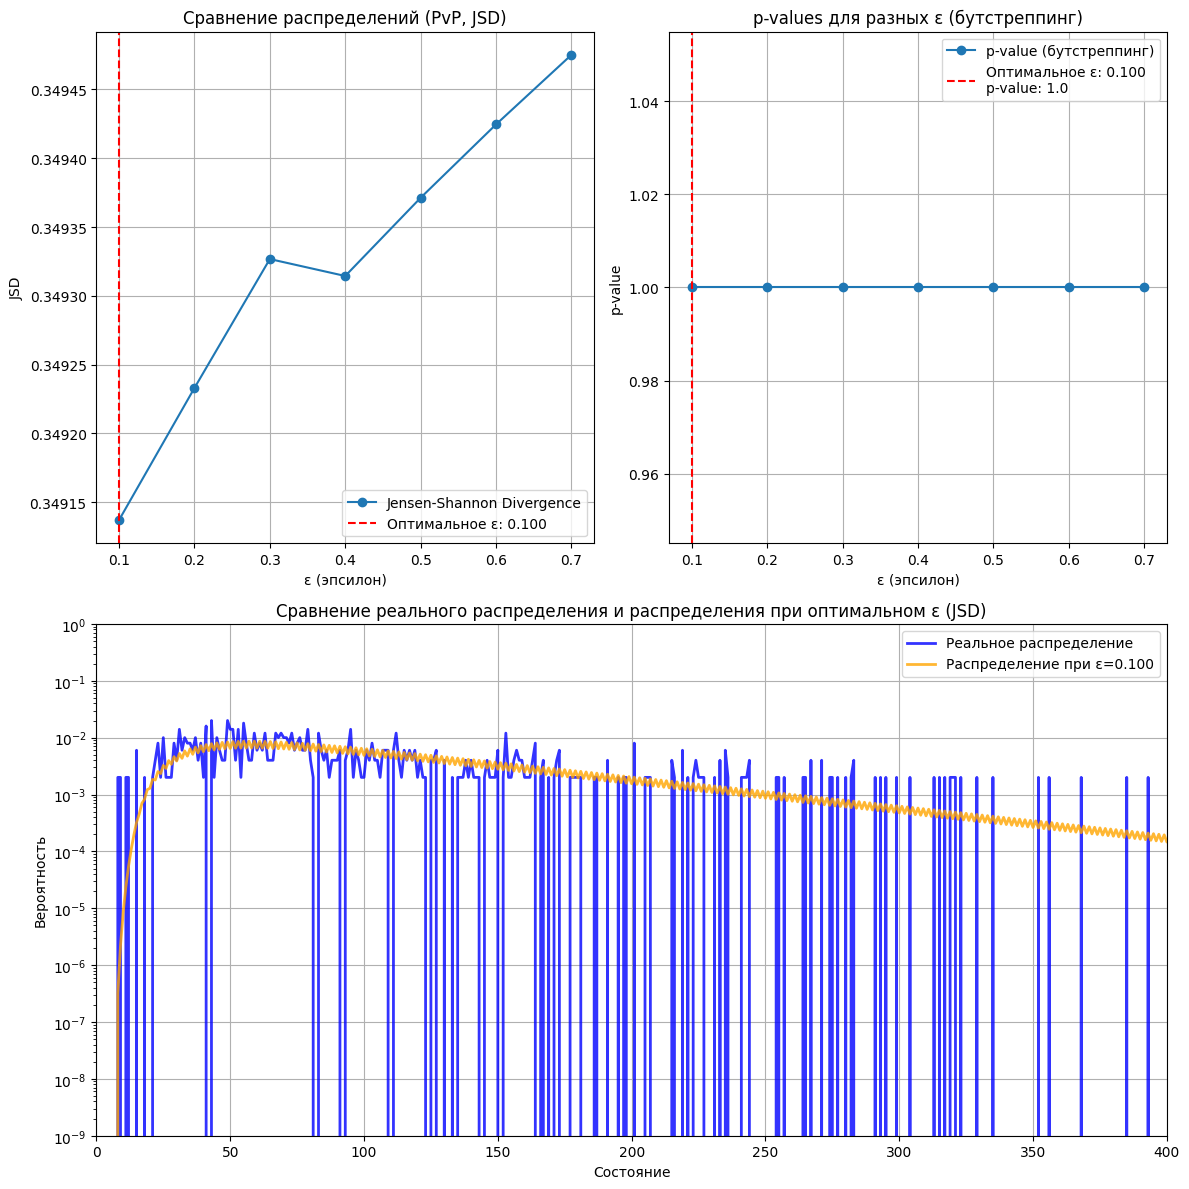

In [83]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_pvp_border_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_border_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (PvP, JSD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_js, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_pvp_border_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_border_js:.3f}\np-value: {optimal_p_value_pvp_border_js}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [prob_real_border[i:i+bin_size].mean() for i in range(0, len(prob_real_border), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_border, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)

plt.plot(prob_real_pvp, label='Реальное распределение', linestyle='-', color='blue', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvp_border_js, label=f'Распределение при ε={optimal_epsilon_pvp_border_js:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
#plt.hist(player_border_turns, bins = bins_ranges_border, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

AD-тест

In [84]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real_pvp, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_pvp_border_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_pvp_border_ad = pmf_epsilon[np.argmin(ad_stats)]
optimal_p_value_pvp_border_ad = ad_p_values[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_pvp_border_ad:.3f}")

Оптимальное ε: 0.100


C:\Users\Илья\AppData\Local\Temp\ipykernel_8012\3174471681.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real_pvp, prob])


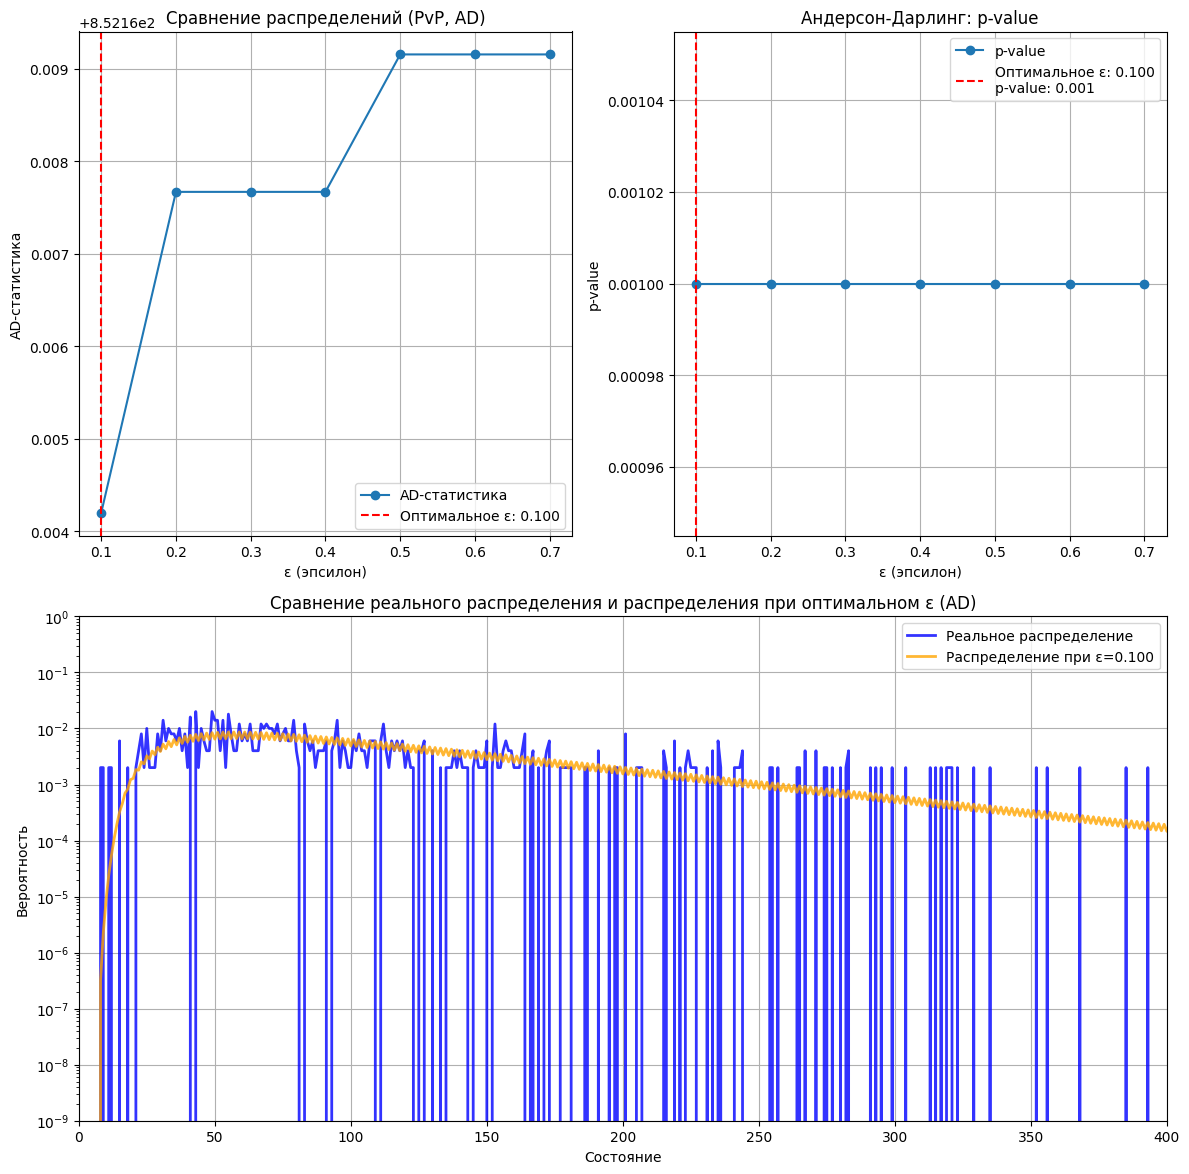

In [85]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_pvp_border_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_border_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Сравнение распределений (PvP, AD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon_pvp_border_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_border_ad:.3f}\np-value: {optimal_p_value_pvp_border_ad}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [prob_real_border[i:i+bin_size].mean() for i in range(0, len(prob_real_border), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_border, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)

plt.plot(prob_real_pvp, label='Реальное распределение', linestyle='-', color='blue', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvp_border_ad, label=f'Распределение при ε={optimal_epsilon_pvp_border_ad:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
#plt.hist(player_border_turns, bins = bins_ranges_border, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Сравнение с распределением центра

KS-тест

In [86]:
#qr_real_matrix, probability_matrix_center, counts_center = get_prob_matrix(N, player_center_states, return_counts=True)
#_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)

p_values_ks = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real_pvp, prob)
    ks_distances.append(ks_stat)
    p_values_ks.append(p_value)

optimal_epsilon_pvp_center_ks = epsilon_vals[np.argmin(ks_distances)]
optimal_prob_pvp_center_ks = pmf_epsilon[np.argmin(ks_distances)]
optimal_p_value_pvp_center_ks = p_values_ks[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon_pvp_center_ks:.3f}")

Оптимальное ε: 0.100


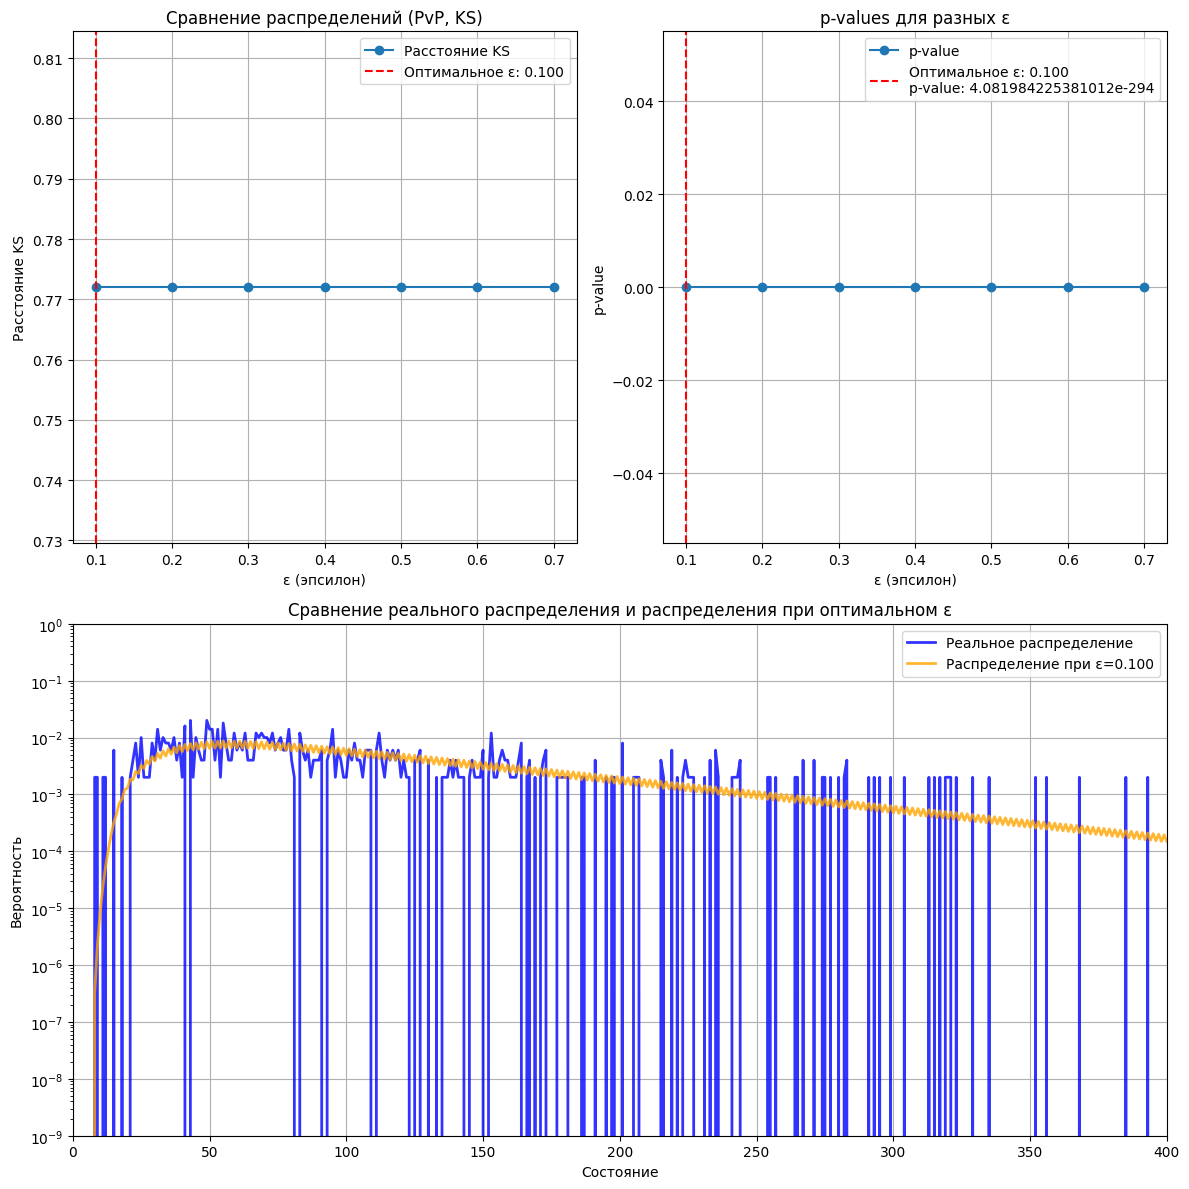

In [87]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon_pvp_center_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_center_ks:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений (PvP, KS)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_ks, marker='o', label='p-value')
plt.axvline(optimal_epsilon_pvp_center_ks, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_center_ks:.3f}\np-value: {optimal_p_value_pvp_center_ks}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [player_center_turns[i:i+bin_size].mean() for i in range(0, len(player_center_turns), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_center, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)

plt.plot(prob_real_pvp, label='Реальное распределение', linestyle='-', color='blue', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvp_center_ks, label=f'Распределение при ε={optimal_epsilon_pvp_center_ks:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
#plt.hist(player_center_turns, bins = bins_ranges_center, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

JSD-тест

In [88]:
from scipy.spatial.distance import jensenshannon

js_distances = []
p_values_js = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real_pvp, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real_pvp, prob)
    p_values_js.append(p_value)

optimal_epsilon_pvp_center_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_pvp_center_js = pmf_epsilon[np.argmin(js_distances)]
optimal_p_value_pvp_center_js = p_values_js[np.argmin(js_distances)]

print(f"Оптимальное ε (JSD): {optimal_epsilon_pvp_center_js:.3f}")

Оптимальное ε (JSD): 0.100


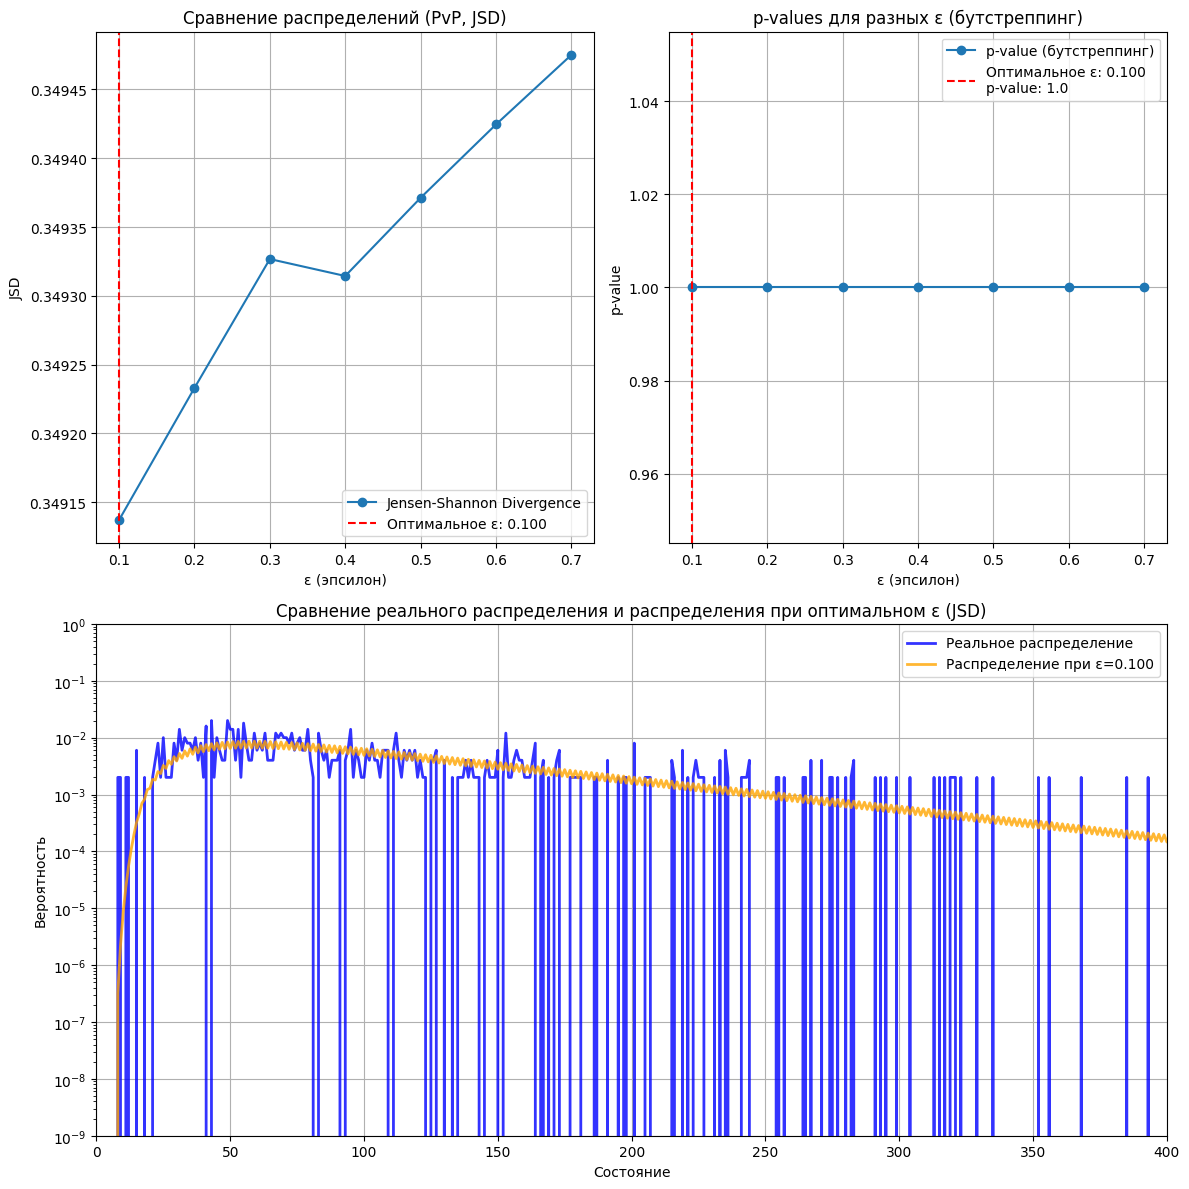

In [89]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_pvp_center_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_center_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (PvP, JSD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, p_values_js, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_pvp_center_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_center_js:.3f}\np-value: {optimal_p_value_pvp_center_js}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [player_center_turns[i:i+bin_size].mean() for i in range(0, len(player_center_turns), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_center, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)

plt.plot(prob_real_pvp, label='Реальное распределение', linestyle='-', color='blue', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvp_center_js, label=f'Распределение при ε={optimal_epsilon_pvp_center_js:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
#plt.hist(player_center_turns, bins = bins_ranges_center, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

AD-тест

In [90]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real_pvp, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_pvp_center_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_pvp_center_ad = pmf_epsilon[np.argmin(ad_stats)]
optimal_p_value_pvp_center_ad = ad_p_values[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_pvp_center_ad:.3f}")

Оптимальное ε: 0.100


C:\Users\Илья\AppData\Local\Temp\ipykernel_8012\3302237145.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real_pvp, prob])


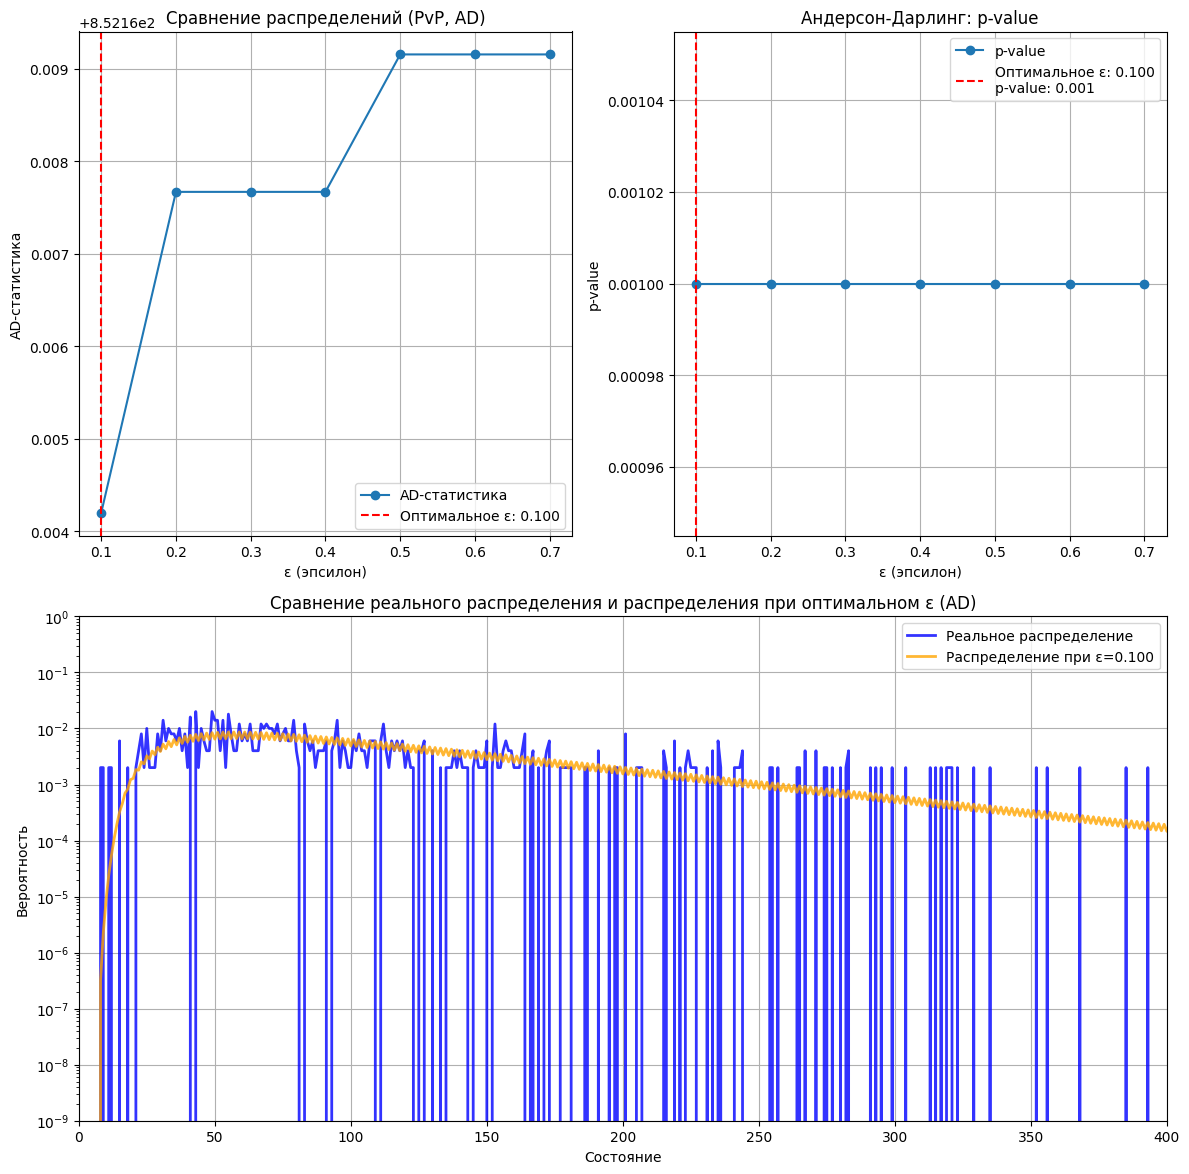

In [91]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_pvp_center_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_center_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Сравнение распределений (PvP, AD)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon_pvp_center_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_pvp_center_ad:.3f}\np-value: {optimal_p_value_pvp_center_ad}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#bin_size = 5
#grouped_data = [player_center_turns[i:i+bin_size].mean() for i in range(0, len(player_center_turns), bin_size)]
#plt.bar(range(len(grouped_data)), grouped_data, width=6, alpha=0.7, label='Реальное распределение')
#plt.plot(prob_real_center, label='Реальное распределение', linestyle='-', color='blue', alpha=0.7, linewidth=2)

plt.plot(prob_real_pvp, label='Реальное распределение', linestyle='-', color='blue', alpha=0.8, linewidth=2)
plt.plot(optimal_prob_pvp_center_ad, label=f'Распределение при ε={optimal_epsilon_pvp_center_ad:.3f}', linestyle='-', color='orange', alpha=0.8, linewidth=2)
#plt.hist(player_center_turns, bins = bins_ranges_center, density=True, color="blue", rwidth=0.9, alpha=0.8, label='Реальное распределение')
plt.xlim(0, 400)
plt.ylim(10e-10, 10e-1)
plt.yscale("log")
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()